### **MA5204: Aprendizaje de Máquinas**

**Departamento de Ingeniería Matemática, Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayudantes:** Alejandro Cuevas, Mauricio Araneda, Mauricio Romero

# Metodos de Monte Carlo

En este notebook se mostraran métodos de muestreo/integración de Monte Carlo, en particular el algoritmo Metrópolis Hastings (MH).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

In [2]:
# contexto notebook  y escala de fuente
sns.set_context('notebook', font_scale=1.6)

# estilo, fondo blanco con 'ticks' en los ejes
sns.set_style('ticks')

# tamaño por defecto de las figuras
plt.rcParams['figure.figsize'] = (12, 5)

## Integración de Monte Carlo

La motivación detras de los métodos de Monte Carlo consiste en aproximar una integral expresada en forma de una esperanza, es decir, dada una función $f:\mathbb{R}^d \rightarrow \mathbb{R}$ se quiere aproximar:

$$I = \mathbb{E}(f(x)) = \int_{\mathcal{X}} f(x) p(x)dx$$


### Motivación
_¿Por qué nos interesa Monte Carlo?_: métodos clasicos de integración numérica (regla de trapazoide, regla de simpson, etc) requieren una malla que escala exponencialmente con el número de dimensiones. 

-_Ejemplo_, si quisiera una malla equiespaciada con paso $1/k$ en un espacio de dimesión $d$, en cada dimensión tendria el vector $[0, 1/k, \ldots, k/k]$, donde finalmente se tendran que hacer $(k+1)^d$ evaluaciones de mi función!.


### Monte Carlo
Utilizando la ley de los grandes números, si tenemos muestras $x_1, x_2, \ldots, x_n$, i.i.d de cierta variable aleatoria $X$ entonces se cumple que,

$$ \frac{1}{n}\sum_{i=1}^{n}x_i\xrightarrow[n \rightarrow \infty]{}  \mathbb{E}(X)$$

Esto nos permite aproximar $I$, tomando muestras i.i.d de $X$ y,

$$ I = \mathbb{E}(f(x)) = \int_{\mathcal{X}} f(x) dx \approx \frac{1}{n} \sum_{i=1}^{n}f(x_i)$$

Esta aproximación converge a la integral y la varianza de la estimación decae proporcional a $1/n$, __Independiente de la dimensión $d$__.

Además, el número de variables aleatorias a simular es lineal con el número de dimensiones.

_El problema_: Debemos poder simular $X$.

### Ejemplo: Área de cuarto de circunferencia

Queremos estimar el área de un cuarto de circunferencia inscrita en el cuadrado $[0, 1] \times [0, 1]$. Es decir, 

$$I =\frac{\pi}{4} = \int_0^1 \int_0^1 \mathbb{1}_{x^2 + y^2 \leq 1} dx dy\$$

Donde nuestra función $f$ es la indicatríz del circulo unitario

$$f(x, y) = \mathbb{1}_{x^2 + y^2 \leq 1} $$

In [3]:
# calculamos el contorno
x = np.linspace(0, 1, 100)
y = np.sqrt(1 - x**2)

Generamos muestras de
$$ X \sim Unif(0, 1)$$ 
Y generamos $N$ muestras $\{x_i, y_i\}_{i=1}^{N}$.

In [4]:
# numero de muestras
N = int(1e4)

# generamos muestras
x_samp = np.random.random(size=(N, 2))

Aplicamos nuestra función indicatriz y graficamos

In [5]:
# funcion indicatriz, solo obtenemos los indices
idx_f = (x_samp**2).sum(1) < 1

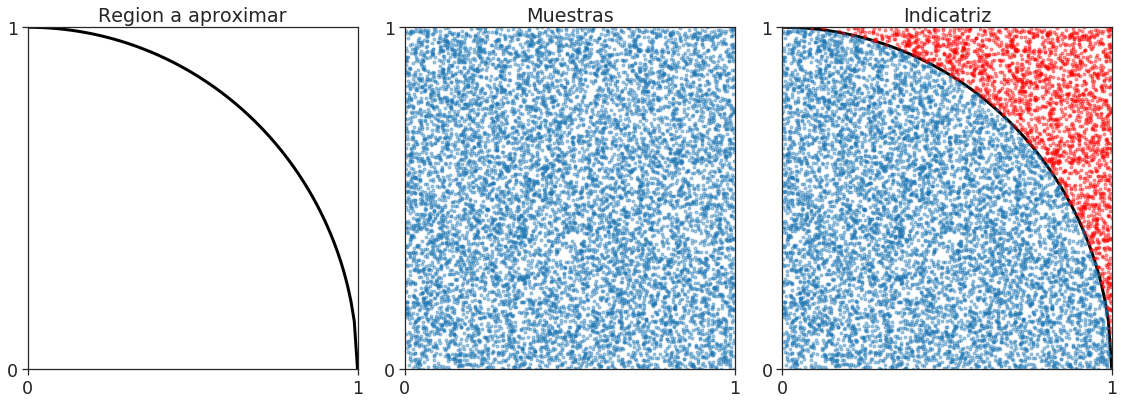

In [6]:
# graficamos

plt.figure(figsize=(16, 6))

plt.subplot(131)
plt.plot(x, y, 'k', lw=3)
plt.title('Region a aproximar')

# limites y ticks
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.subplot(132)
plt.plot(x_samp[:, 0], x_samp[:, 1], 'o', ms=3, alpha=0.4)
plt.title('Muestras')

# limites y ticks
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.subplot(133)
plt.plot(x, y, 'k', lw=3)
plt.plot(x_samp[idx_f, 0], x_samp[idx_f, 1], 'o', ms=3, alpha=0.4)
plt.plot(x_samp[~idx_f, 0], x_samp[~idx_f, 1], 'or', ms=3, alpha=0.4)
plt.title('Indicatriz')

# limites y ticks
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.tight_layout()

Finalmente aproximamos la integral

In [7]:
# creamos vector de ceros
f_x = np.zeros(N)
# asignamos 1 por la indicatriz
f_x[idx_f] = 1

print('Valor real', np.pi/4)
print('Aproximación Monte Carlo', f_x.mean())

Valor real 0.7853981633974483
Aproximación Monte Carlo 0.7915


# Markov Chain Monte Carlo (MCM)

El método de Monte Carlo sirve siempre que podamos muestrear de la distribución, pero ¿Qué pasa cuando esto no es posible?
Métodos MCMC permiten muestrear distribuciones que son __conocidas, hasta una constante multiplicativa__.

Un caso común de esto se tiene en el contexto de __estimación Bayesiana__, donde la posterior es de la forma:

$$ p(\theta|x) = \frac{p(x|\theta) p(\theta)}{p(x)}$$

Donde en la mayoria de las veces se puede evaluar el prior, $p(x)$ y la verosimilitud, $p(x|\theta)$, pero la evidencia $p(x)$ es intractable, pues es infactible evaluar,

$$ p(x) = \int_{\Theta} p(x, \theta) d\theta = \int_{\Theta} p(x|\theta)p(\theta) d\theta$$

Los métods MCMC se basan en simular una Cadena de Markov Homogenea, con distribución de equilibrio $\pi$, donde en virtud del Teorema Ergódico podemos aproximar,

\begin{align}
I & = \mathbb{E}_{\pi}[f(x)] = \int_{\mathcal{X}} f(x) \pi(x) dx\\
  & \approx \frac{1}{n} \sum_{i=1}^{n}f(x_i)
\end{align}

Para esto, nuestra cadena debe ser aperiodica y recurrente positiva.

__De esta forma, podemos aproximar $p(x)$ si es que la distribución de equilibrio $\pi$ es igual a nuestra posterior!!__

---

## Metropolis-Hastings

_¿Como construimos una cadena que tenga esta distribución como distribución en equilibrio?_

Una forma de hacerlo es mediante el algoritmo Metropolis-Hastings (1953/1930)
El algoritmo funciona de la forma:
0. Elegir una distribución _proposal_ $q(x_t|x_{t-1})$
1. Generar un punto inicial $x_0$.
2. Para cada iteración $t$:
    1. Para el instante $t+1$, generar un candidato muestreando: $$x^c \sim q(x_t|x_{t-1})$$
    2. Calcular probabilidad de aceptación: $$r = min\left[1, \frac{p(x^c)q(x_t|x^c)}{p(x_t)q(x^c|x_t)} \right]$$
    3. Aceptar el candidato $x^c$ con probabilidad $r$, con una realización de una v.a. Ber($r$)
    4. Aceptación/rechazo:
        1. Si se acepta $x_{t+1}=x^c$
        2. Si se rechaza $x_{t+1}=x_t$

### Ejemplo: Modelo Gaussiano
Ejemplo inspirado de [[1]](https://blog.quantopian.com/mcmc-sampling-for-dummies/).

Se tienen $n$ observaciones $Y=\{y_i\}_{i=1}^{n}$ es una normal de media __desconocida__ $a$ y varianza conocida $\sigma^2$, esto es,

$$ x_i \sim \mathcal{N}(a, \sigma^2)$$

Donde imponemos un prior Normal$(0, 1)$ sobre $a$, 

$$a \sim \mathcal{N}(0, 1)$$

Bajo esta formulación, podemos obtener la densidad posterior de $a$, condicional a las observaciones $X$ de forma cerrada, puesto que la distribución Gaussiana es conjugada de si misma.

\begin{align}
p(a|Y) & = \frac{p(Y|a)p(a)}{p(Y)}\\
       & = \mathcal{N}(\mu_{post}, \sigma_{post}^2)\\
       & = \mathcal{N}\left(\frac{\sum_{i=1}^{n} y_i}{n+\sigma^2}, \frac{\sigma^2}{n+\sigma^2} \right)  \quad\quad(*)
\end{align}

Por lo que podemos estimar esta densidad posterior con MH y compara con la densidad posterior real.

__Diseño MH:__

Identifiquemos los terminos en el algoritmo mostrado:

0. Como queremos la posterior sobre $a$, el espacio de estados será $\mathbb{R}$, donde los $x_t$ del algoritmo son posibles medias $a_t$.
1. Usamos una proposal ~~muy creativa~~ Gaussiana, 

$$q(a_t|a_{t-1}) = \mathcal{N}(a_{t-1}, \tau^2)$$

Notemos que en este caso el __proposal es simétrico__, por lo que obtenemos el algoritmo Metropolis.

2. $p(a_t)$ es la posterior buscada, es decir,
$$ p(a_t) = p(a_t|Y) \propto p(Y|a_t)p(a_t)$$

__Comenzamos generando los datos__

a = 1.6243453636632417


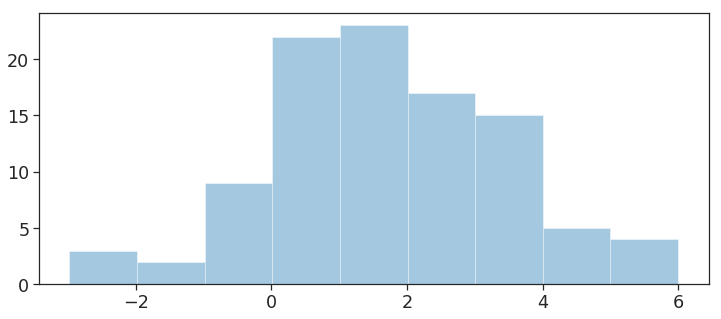

In [8]:
# fijar seed para poder repetir experimento
np.random.seed(1)

# numero de obs
n = 100

# Desviacion estandar
sigma = 2

# generar a
a = np.random.normal()
print('a =', a)

# generar obs
Y = np.random.normal(loc=a, scale=sigma, size=n)

sns.distplot(Y, kde=False);

__Luego nos definimos nuestras funciones para poder evaluar la posterior y MCMC__

In [9]:
def posterior_analitica(y_obs, sigma=sigma):
    """
    Calcula la posterior analitica mostrada en (*)
    x : Observaciones 
    sigma : varianza conocida de la distribucion.
    """
    n_obs = len(y_obs)
    # media de la posterior
    mu_post = y_obs.sum() / (n_obs + sigma**2)
    
    # varianza de las posterior
    sigma_post = np.sqrt(sigma**2 / (n_obs + sigma**2))
    
    return mu_post, sigma_post

def verosimilitud_G(mu, y_obs=Y, sigma=sigma):
    """
    Verosimilitud Gaussiana para obs i.i.d
    y_obs : Observaciones
    mu : media
    sigma : desviacion estandar
    """
    n_obs = len(y_obs)
    L = np.exp(-((y_obs - mu)**2).sum() / (2 * sigma**2))
    
    return L / (np.sqrt(2 * np.pi * sigma**2))**n

def prior_G(mu, mu_prior=0, sigma_prior=1):
    """
    Prior Gaussiano, por defecto es N(0, 1)
    """
    prior = np.exp(-(mu - mu_prior)**2 / (2 * sigma_prior**2))
    
    return prior / np.sqrt(2 * np.pi * sigma_prior**2)

__Grafiquemos la posterior analitica__

Text(0.5, 1.0, 'Posterior analítica')

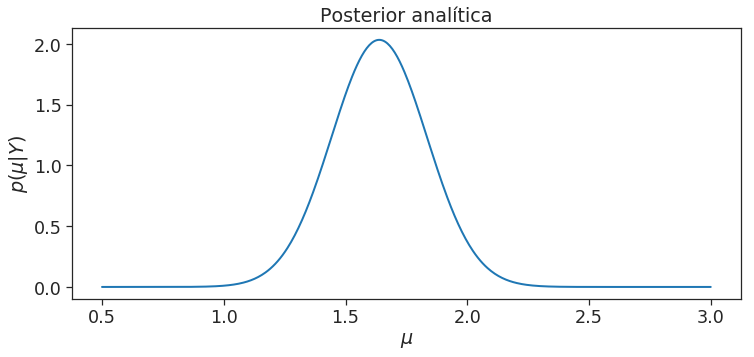

In [10]:
# posterior analitica
mu_post, sigma_post = posterior_analitica(Y)

# puntos a evaluar
x = np.linspace(0.5, 3, 500)
true_post = norm.pdf(x, loc=mu_post, scale=sigma_post)

plt.plot(x, true_post, lw=2)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu|Y)$')
plt.title('Posterior analítica')

__Definamos nuestro sampler__

In [11]:
def mh_sampler(n_iter=100, y_obs=Y, x0=None, tau=2):
    """
    Metropolis Hastings sampler.
    
    n_iter : Número de iteraciones.
    y_obs : Observaciones.
    x0 : Punto inicial
    tau : varianza del proposal.
    """
    # si no especifico punto inicial, saca uno al azar
    if x0 is None:
        x0 = np.random.normal()
    
    # contenedor para guardar las muestras
    X = np.zeros(n_iter + 1)
    # asigno primer valor
    X[0] = x0
    
    for it in range(1, n_iter + 1):
        # generar proposal
        x_c = np.random.normal(X[it - 1], tau)
        
        # probabilidad aceptacion
        num = verosimilitud_G(x_c) * prior_G(x_c)
        denom = verosimilitud_G(X[it - 1]) * prior_G(X[it - 1])
        # probabilidad
        r = min(num / denom, 1)
        
        # realizacion Bernoulli para aceptar
        accept = np.random.random() < r
        
        if accept:
            X[it] = x_c
        else: 
            X[it] = X[it - 1]

    return X

__Obtengamos muestras__

In [12]:
# numero de muestras
n_samples = 2000

# obtenemos 2 cadenas
chain1 = mh_sampler(n_samples, tau=1)
chain2 = mh_sampler(n_samples, tau=10)

__Grafiquemos__

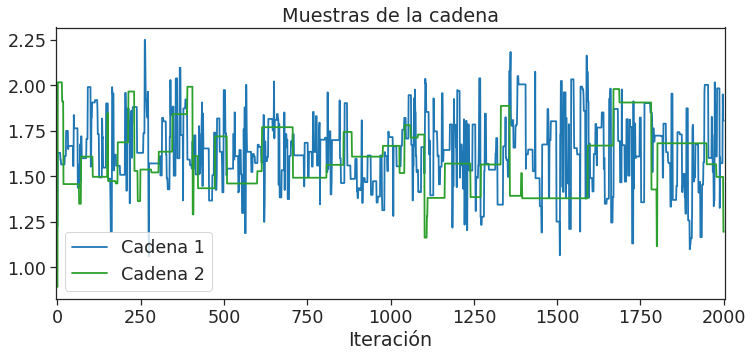

In [13]:
plt.plot(chain1, lw=1.8, label='Cadena 1')
plt.plot(chain2, lw=1.8, label='Cadena 2', c=sns.color_palette()[2])

plt.xlabel('Iteración')
plt.title('Muestras de la cadena')
plt.xlim(-5, n_samples + 5)
plt.legend()

Text(0.5, 1.0, 'Histograma de las cadenas')

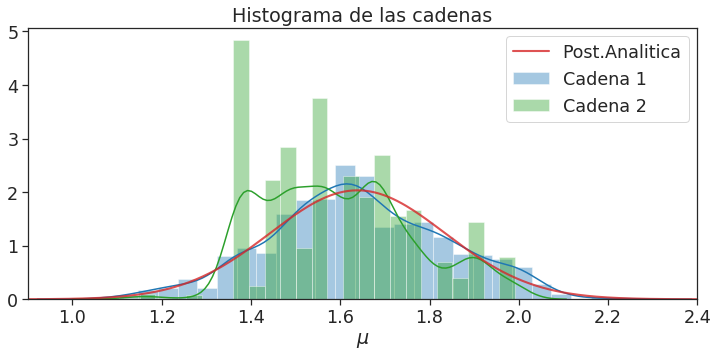

In [14]:
# muestras a quemar
n2burn = 100

# histograma
sns.distplot(chain1[n2burn:], label='Cadena 1')
sns.distplot(chain2[n2burn:], label='Cadena 2', color=sns.color_palette()[2])
plt.plot(x, true_post, label='Post.Analitica', lw=2.1, c=sns.color_palette()[3], alpha=0.8)
plt.legend()
plt.xlim(0.9, 2.4)
plt.xlabel(r'$\mu$')
plt.title('Histograma de las cadenas')